In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
from math import log2
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# inputFiles = ['../CMS-EXO-20-004/scanResults_scalar_cms_nocut.pcl', 
#               '../CMS-EXO-20-004/scanResults_pseudoscalar_cms_nocut.pcl']

inputFiles = ['../vector_nocut.pcl',
              '../axial_nocut.pcl']


dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get all model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$', '$g_{DM}$', '$g_{q}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

210 models loaded.


### Get models parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Axial', 'Vector'], 'Mode': 'DM+QCDjets', '$m_{med}$': [10.0, 145.0, 295.0, 300.0, 3000.0, 2750.0, 2500.0, 2250.0, 1995.0, 2000.0, 1750.0, 1500.0, 1250.0, 995.0, 100.0, 1000.0, 750.0, 500.0, 250.0], '$m_{DM}$': [1000.0, 10.0, 300.0, 750.0, 1200.0, 500.0, 150.0, 1400.0], '$g_{DM}$': 1.0, '$g_{q}$': 0.25}
Coupling = ['Axial', 'Vector']
Mode = DM+QCDjets
$g_{DM}$ = 1.0
$g_{q}$ = 0.25


### Filter parameters

In [5]:
paramFilter = {
    'Mode' : 'DM+QCDjets',
    '$m_{med}$' : 10.,
    '$m_{DM}$' : 1200.,
    '$g_{DM}$' : 1.,
#     '$g_{q}$' : .25,
    'Data-takingperiod' : 2017
}

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in paramFilter.items()])
dfModel = recastData.loc[(recastData[list(paramFilter)] == pd.Series(paramFilter)).all(axis=1)]

In [6]:
dfModel.T

,16,337
Coupling,Vector,Axial
Mode,DM+QCDjets,DM+QCDjets
$m_{med}$,10.0,10.0
$m_{DM}$,1200.0,1200.0
Data-takingperiod,2017,2017
Luminosity (1/fb),41.5,41.5
bin_250.0_280.0,0.184448,0.041094
bin_250.0_280.0_ErrorPlus,0.009659,0.002239
bin_250.0_280.0_ErrorMinus,0.009659,0.002239
bin_280.0_310.0,0.154347,0.02901


The efficiency for the $i$-th bin, $\epsilon_{i}$, is given by:

$$ \epsilon_{i} = \frac{n^{i}_{s}}{\sigma_{T}\mathcal{L}},   $$
where $n^{i}_{s}$ is the number of events in the correspondent bin, $\sigma_{T}$ is the total cross-section, and $\mathcal{L}$ is the integrated luminosity.  

### Auxiliar functions for plotting

In [7]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binsError,binCenter,binLeft


def getEfficiencies(dfSingle, bins, binsError):
    
    xsec = dfSingle['Total xsec-pT150 (pb)'].iloc[0]
    lumi = dfSingle['Luminosity (1/fb)'].iloc[0]
    eff = {}
    ns = {c: dfSingle[c].iloc[0] for c in bins}
    nsErr = {c : dfSingle[c].iloc[0] for c in binsError}
    effErr = {}
    for c in bins:
        if ns[c] == 0:
            eff[c] = 0
            effErr[f'{c}_Error'] = 0
        else:
            eff[c] = dfSingle[c].iloc[0]/(xsec*1e3*lumi)
            effErr[f'{c}_Error'] = nsErr[f'{c}_ErrorPlus']*eff[c]/ns[c]
    
    return eff, effErr

### Plot Efficiencies

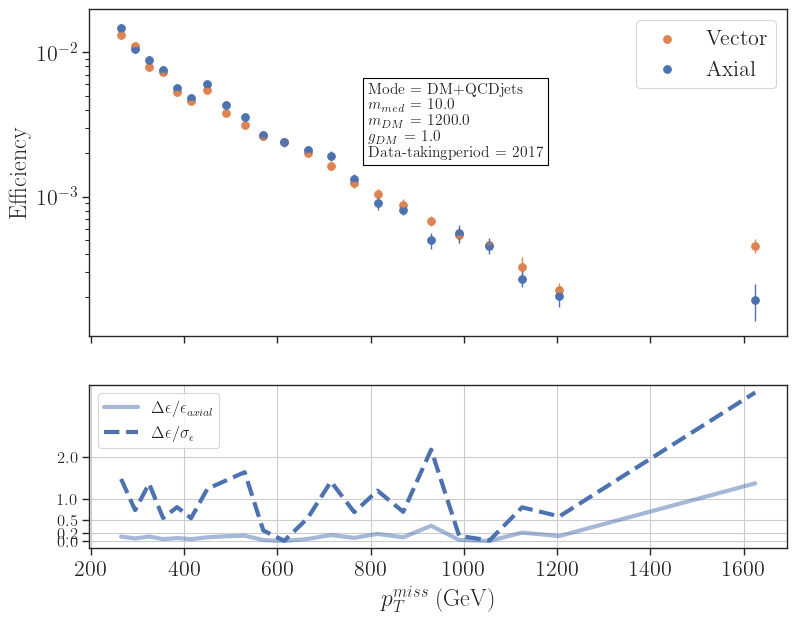

In [8]:
bins, binsError, binCenter, binLeft = getBins(dfModel)

fig, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(9,7))

data = pd.DataFrame(columns=['Axial', 'Vector'])
dataError = pd.DataFrame(columns=['Axial', 'Vector'])

# data = pd.DataFrame(columns=['Scalar', 'Pseudoscalar'])
# dataError = pd.DataFrame(columns=['Scalar', 'Pseudoscalar'])

colors = {label : sns.color_palette('deep')[i] for i,label in enumerate(data.keys())}    

for label in dfModel['Coupling']:
    dfSingle = dfModel[dfModel['Coupling'] == label]
    data[label], dataError[label] = getEfficiencies(dfSingle, bins, binsError)
 
    eff = np.array([data[label][c] for c in bins])
    effErr = np.array([dataError[label][f'{c}_Error'] for c in bins])
    
    ax[0].scatter(x=binCenter, y=eff, s=30, color=colors[label], label=label)
    ax[0].errorbar(binCenter, eff, yerr=effErr, marker='.', 
                   elinewidth=1.0, drawstyle='steps-mid',linewidth=0.0, color=colors[label])

diff = np.abs(data.Axial - data.Vector)

# diff = np.abs(data.Pseudoscalar - data.Scalar)

relDiff = diff/data.Axial
# relDiff = diff/data.Pseudoscalar

relDiff = relDiff.replace(np.nan, 0)

diffError = np.array(diff)/np.sqrt(dataError.Axial**2 + dataError.Vector**2)
diffError = diffError.replace(np.nan, 0)
# diffError = np.array(diff)/np.sqrt(dataError.Pseudoscalar**2 + dataError.Scalar**2)
# diffError = diffError.replace(np.nan, 0)

label1 = r'$\Delta \epsilon / \epsilon_{axial}$'
# label1 = r'$\frac{\mbox{Axial-Vector}}{\mbox{Axial}}$'
label2 = r'$\Delta \epsilon / \sigma_{\epsilon}$'

ax[1].plot(binCenter, relDiff, color=colors[label], linewidth=3., label=label1, alpha=.5)
ax[1].plot(binCenter, diffError, color=colors[label], linewidth=3., linestyle='--', 
           label=label2)

    
ax[0].set_yscale('log')
ax[0].text(.4, 2.4, textstr, fontsize=11, bbox=dict(facecolor='none', edgecolor='black'), 
           transform=plt.gca().transAxes)



ax[0].set_ylabel('Efficiency')
ax[0].legend()

# ax[1].set_ylim(0., 2.)
ax[1].legend(fontsize='12')
ax[1].grid(True)
ax[1].set_yticks([0., 0.2, 0.5, 1., 2.])
ax[1].tick_params(axis='y', labelsize='12')
ax[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
# ax[1].set_ylabel('Relative diff.')

plt.show()

In [12]:
eff

array([0.0148594 , 0.01049001, 0.00886361, 0.00759938, 0.00570106,
       0.00482227, 0.00602937, 0.00429708, 0.00356414, 0.00267982,
       0.00238559, 0.0021038 , 0.00190912, 0.00133294, 0.00089894,
       0.00080846, 0.00049758, 0.00055661, 0.00045768, 0.00027013,
       0.00020285, 0.00019183])

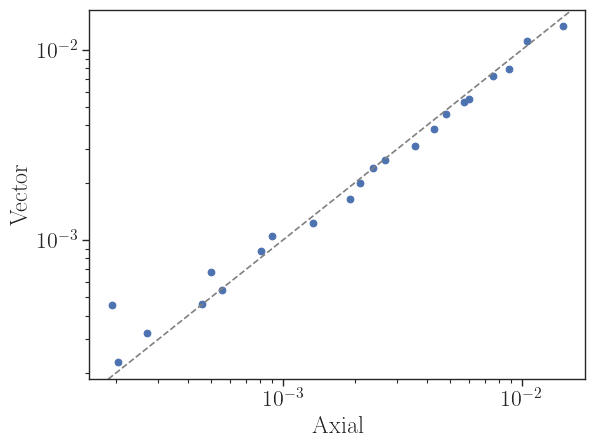

In [9]:
## Q-Q plot
plt.scatter(x = data.Axial, y = data.Vector)
# plt.scatter(x = data.Pseudoscalar, y = data.Scalar)

plt.axline((0,0), slope=1, linestyle='--', color='gray')

plt.xlabel('Axial')
plt.ylabel('Vector')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [10]:
relDiff.max()

1.3703493550658201

In [11]:
data.Axial

bin_250.0_280.0      0.014859
bin_280.0_310.0      0.010490
bin_310.0_340.0      0.008864
bin_340.0_370.0      0.007599
bin_370.0_400.0      0.005701
bin_400.0_430.0      0.004822
bin_430.0_470.0      0.006029
bin_470.0_510.0      0.004297
bin_510.0_550.0      0.003564
bin_550.0_590.0      0.002680
bin_590.0_640.0      0.002386
bin_640.0_690.0      0.002104
bin_690.0_740.0      0.001909
bin_740.0_790.0      0.001333
bin_790.0_840.0      0.000899
bin_840.0_900.0      0.000808
bin_900.0_960.0      0.000498
bin_960.0_1020.0     0.000557
bin_1020.0_1090.0    0.000458
bin_1090.0_1160.0    0.000270
bin_1160.0_1250.0    0.000203
bin_1250.0_1400.0    0.000192
Name: Axial, dtype: float64